In [ ]:
!nvidia-smi

Fri Jan 20 13:46:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

'/device:GPU:0'

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.077552593000007
GPU (s):
0.03647782999999549
GPU speedup over CPU: 84x


In [ ]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp38-cp38-linux_x86_64.whl size=661775 sha256=c6ea6aaef4970f34e29383ae6c582671bca7a61981ea5763eff01c567814166d
  Stored in directory: /root/.cache/pip/wheels/7b/41/0d/7cecb04af969d283ebe4a69579a8b2baec0d010a1ac4159f7e
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69870 sha256=3d2d16447cde280ff8b978f5279906c88a8fed2c89c63b7ffbace90d5b2b0485
  Stored in directory: /root/.cache/pip/wheels/cb/fc/

Number of Rows -  64
Features -  8
Shape of Input Matrix= (64, 8)
Time Taken by Python Naive Vector Distance in Seconds
28.95188331604004
Time Taken by GPU Naive Vector Distance in Seconds
3.205471992492676


----------------------------------------
-------Vector Distance Matched---------
----------------------------------------



Number of Rows -  256
Features -  8
Shape of Input Matrix= (256, 8)
Time Taken by Python Naive Vector Distance in Seconds
684.9818229675293
Time Taken by GPU Naive Vector Distance in Seconds
17.005823135375977


----------------------------------------
-------Vector Distance Matched---------
----------------------------------------



Number of Rows -  1024
Features -  8
Shape of Input Matrix= (1024, 8)
Time Taken by Python Naive Vector Distance in Seconds
7792.328357696533
Time Taken by GPU Naive Vector Distance in Seconds
30.95350456237793


----------------------------------------
-------Vector Distance Matched---------
-----------------------------------

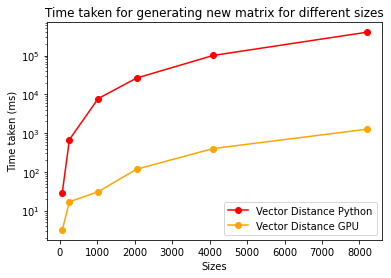

In [ ]:
import math
import time
import numpy as np
import pycuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
from scipy import signal
import sys 
import pycuda.autoinit
import matplotlib
import matplotlib.pyplot as plt 

class VectorDistance:

   def __init__(self):
      """ 
      Attributes for instance of EncoderDecoder module
      """
      self.mod = self.getSourceModule()
      pass
   
   def getSourceModule(self):
      # kernel code wrapper
      kernelwrapper = """ 
      #include<stdio.h>
      /* Vector Distance GPU Naive Method  ---> 
         matrixSamples - inputMatrix i.e. rowsCount * featureCount 
         result - to store the output of vectorDistance
         ** if 5 rows are there in the input table, we need 25 rows of output.
            i.e. Dij is the distance between ith point to jth point. 
            So, for every point, we need it distance between all the other points. 
            Hence threads are invoked in both X & Y direction. 
      */
      __global__ void vectorDistance_gpuNaive(float *matrixSamples, 
                                              float *result, 
                                              int rowsCount, 
                                              int featuresCount)
      {
         /*
            ** threads in X and Y direction
         */
         int idx = blockIdx.x * blockDim.x + threadIdx.x; 
         int idy = blockIdx.y * blockDim.y + threadIdx.y; 
         /* 
            ** If ith thread is same as jth thread in 2-d matrix, then the calculation
               is like D11 i.e. distance of 1st point with the 1st point only. Hence
               it can be directly written as zero
            ** else
                  we will be calculating the eucidean distance between the points 
                  and storing in the result matrix. 
         */
         if(idx<rowsCount && idy < rowsCount && idx!=idy) 
         {
            float euclideanDistance = 0.0;
            for(int k=0;k<featuresCount;k++)
            {
               euclideanDistance += pow((matrixSamples[idx*featuresCount+k]-
                                         matrixSamples[idy*featuresCount+k]),2);
            }
            result[idx*rowsCount+idy] = sqrt(euclideanDistance);
         }
         if(idx<rowsCount && idy < rowsCount && idx==idy)
         {  
            result[idx*rowsCount+idy] = 0.0;
         } 
      }
      /* <---- Vector Distance GPU Naive Method */
      """
      # you can either use a string or save the kernel in kernel.cu file and reference it here.
      # Compile the kernel code when an instance
      # of this class is made. 
      return SourceModule(kernelwrapper)

   '''
      VectorDitance GPU Naive 
         - method to invoke the kernel. 
         _matrix - dataset sample with rowsCount * featuresCount
         1) starting time event
         2) copying matrix of input and result to to gpu
         3) Invokation of threads based on the logic:
            --> if n*n <=1024, then we just need 1 block of threads for the final output
            --> else we will need blocks = math.ceil(rowsCount/32) in both X & Y direction. 
         4) Invoking the kernel : vectorDistance_gpuNaive and getting back the results.
         5) end the time event
   '''
   def vectorDistance_gpu(self,_matrix, rowsCount,featuresCount):
      
      startWithMemTransfer=cuda.Event()
      endWithMemTransfer=cuda.Event()
      startWithMemTransfer.record()

      gpu_matrix = gpuarray.to_gpu(_matrix)

      _resultMatrix= np.random.rand(rowsCount,rowsCount).astype(np.float32)
      gpu_result  = gpuarray.to_gpu(_resultMatrix)
      #_result = gpuarray.zeros_like(gpu_result)

      vdResult = np.empty_like(_matrix)
      rowsCountValue = np.uintc(rowsCount)
      featuresCountValue = np.uintc(featuresCount)

      if(rowsCount * rowsCount <= 1024):
         blockDim_X = rowsCount
         blockDim_Y = rowsCount
         gridDim_X  = 1
         gridDim_Y  = 1
      else:
         blockDim_X = 32
         blockDim_Y = 32
         gridDim_X = math.ceil(rowsCount/32)
         gridDim_Y = math.ceil(rowsCount/32)

      func = self.mod.get_function("vectorDistance_gpuNaive")

      func(gpu_matrix,
            gpu_result,
            rowsCountValue,
            featuresCountValue,
            block = (blockDim_X,blockDim_Y,1),
            grid = (gridDim_X,gridDim_Y,1)
           )

      vdResult = gpu_result.get()

      endWithMemTransfer.record()
      endWithMemTransfer.synchronize()
      timeWithMemTransfer=startWithMemTransfer.time_till(endWithMemTransfer)

      return vdResult,timeWithMemTransfer

   '''
      VectorDitance Python Serial Implementation  
         matrixSamples - dataset sample with rowsCount * featuresCount
         result - to store the output. 
         1) starting time event
         2) Logic to impute vector distance
            --> for all elements in array:
               --> for all elements in array:
                  --> if i==j then distance is 0
                  --> else calculate the eucildean distance bwteen Di,j
         3) end the time event
   '''
   def vectorDistance_python(self,matrixSamples,rowsCount,featuresCount,result):
      start = time.time()
      for i in range(0,rowsCount):
         for j in range(0, rowsCount):
            if(i==j):
               result[i][j] = 0
            else:
               euclideanDistance=0;
               for k in range(0,featuresCount):
                  euclideanDistance += math.pow((matrixSamples[j][k]-matrixSamples[i][k]),2)
               result[i][j]=math.sqrt(euclideanDistance)
      end = time.time()
      # converting to milliseconds.
      time_ = (end-start)*1000
      return result,time_   

'''
   Main function to invoke both vector distance 
   serially on python and parallely on GPU, for 
   various sizes # 64,256,1024,2048,4096,8192.
'''
if __name__ == "__main__":

   vd = VectorDistance()

   size = [64,256,1024,2048,4096,8192]
   timeVDSerial = []
   timeVDGPU = []

   for i in range(len(size)):
      numberofRows = size[i]
      features =8

      #-----------------Input Matrix ---------------------------------------------------->
      '''
      matrixSamples = np.array([[1,3,4,5,4],
                                   [4,3,2,5,7],
                                   [5,9,2,8,6],
                                   [1,2,4,6,7],
                                   [6,5,6,7,2]
                                  ])
      '''
      matrixSamples = np.random.rand(numberofRows,features)
      matrixSamples = matrixSamples.astype(np.float32)

      print("Number of Rows - ",numberofRows)
      print("Features - ",features)

      #print("Input Matrix\n")
      #print(matrixSamples)

      print("Shape of Input Matrix=",matrixSamples.shape)
      
      #<-------------------------------------------------------------------------------------

      #------------ Python Naive Vector Distance -------------------------------------------->
      resultVD_Python = np.random.rand(matrixSamples.shape[0],
                                       matrixSamples.shape[0])
      resultVD_Python = resultVD_Python.astype(np.float32)    
      
      vd_python, time_vd_python = vd.vectorDistance_python(matrixSamples,
                                                              matrixSamples.shape[0],
                                                              matrixSamples.shape[1],
                                                              resultVD_Python)

      #print("\nPython Naive Output Vector Distance\n")
      #print(vd_python)

      print("Time Taken by Python Naive Vector Distance in Seconds")
      print(time_vd_python)
      
      timeVDSerial.append(time_vd_python)
      #<------------------------------------------------------------------------------------
       
      #----------------- GPU Naive Vector Distance -----------------------------------------> 
      vd_gpu,time_vd_gpu = vd.vectorDistance_gpu(matrixSamples,
                                                    matrixSamples.shape[0],
                                                    matrixSamples.shape[1])

      #print("\nGPU Naive Output Vector Distance\n")
      #print(vd_gpu)

      print("Time Taken by GPU Naive Vector Distance in Seconds")
      print(time_vd_gpu)
    
      print("\n")
      timeVDGPU.append(time_vd_gpu)
      #<--------------------------------------------------------------------------------------

      #----------------- Comparision Vector Distan--------------------->
      if(np.allclose(vd_gpu, vd_python, atol=1e-05)):
         
         print("----------------------------------------")
         print("-------Vector Distance Matched---------")
         print("----------------------------------------")
      else:
         print("Vector Distance NOT MATCHED!")

      #------------------------------------------------------------

      print("\n\n")

   plt.xlabel("Sizes")
   plt.ylabel("Time taken (ms)")
   plt.yscale('log')
   plt.title("Time taken for generating new matrix for different sizes")
   plt.plot(size,timeVDSerial,label='Vector Distance Python',color="red",marker='o')
   plt.plot(size,timeVDGPU,label='Vector Distance GPU',color="orange",marker='o')
   plt.legend()

Number of Rows -  64
Features -  4
K -  3


Input Matrix

[[4.02524650e-01 9.89666641e-01 3.37229252e-01 4.22490358e-01]
 [6.84583426e-01 4.93725330e-01 3.48138005e-01 7.27833033e-01]
 [3.42786342e-01 9.60051894e-01 8.52814674e-01 2.98019737e-01]
 [9.07398283e-01 4.01982069e-01 5.18504381e-01 2.99185157e-01]
 [8.72909248e-01 4.52046543e-01 5.86743951e-01 5.55260658e-01]
 [9.76612926e-01 2.89479196e-02 7.17050552e-01 3.82631063e-01]
 [6.53337777e-01 5.22433221e-01 9.78043795e-01 2.20950752e-01]
 [9.77363050e-01 2.26007074e-01 9.24669743e-01 3.95715644e-04]
 [1.89809814e-01 4.51543331e-01 9.36308205e-01 4.27565932e-01]
 [5.69615364e-01 2.19342560e-01 2.91456044e-01 9.74286124e-02]
 [9.39141989e-01 3.63740474e-01 4.82334346e-01 9.72902417e-01]
 [8.80687773e-01 1.67430952e-01 6.62353575e-01 2.17712104e-01]
 [6.14328623e-01 4.42759097e-02 2.25024536e-01 2.08651781e-01]
 [5.28641045e-01 7.68471420e-01 6.68952048e-01 2.36728907e-01]
 [7.79813111e-01 8.48264933e-01 1.42937317e-01 1.75313994e-0

/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: event in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None



New Points For the Matrix Through KNN Algorithm in GPU Naive

[[0.21686801 0.670359   0.7245493  0.13692102]
 [0.8871654  0.77378994 0.08685184 0.17801367]
 [0.23291795 0.15732522 0.17032838 0.39299387]
 ...
 [0.5051713  0.4514727  0.8816427  0.7078453 ]
 [0.25915664 0.47712085 0.15910548 0.89985645]
 [0.8173247  0.8045492  0.7053093  0.7556826 ]]

 Time Taken by GPU  CPU SORT KNN

32381.16015625



-----------------------------------------------------
----------KNN GPU SHARED  MATCHED-------------------
-----------------------------------------------------


New Matrix Appended with Old Matrix
Shape of Output Matrix = (32768, 4)


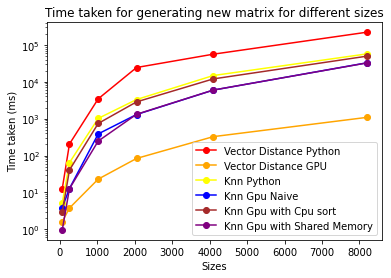

In [ ]:
import math
import time
import numpy as np
import pycuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
from scipy import signal
import sys 
import pycuda.autoinit
import matplotlib
import matplotlib.pyplot as plt 

class Smote:

   def __init__(self):
      """ 
      Attributes for instance of EncoderDecoder module
      """
      self.mod = self.getSourceModule()
      pass
   
   def getSourceModule(self):
      # kernel code wrapper
      kernelwrapper = """ 
      #include<stdio.h>
      /* Vector Distance GPU Naive Method  ---> 
         matrixSamples - inputMatrix i.e. rowsCount * featureCount 
         result - to store the output of vectorDistance
         ** if 5 rows are there in the input table, we need 25 rows of output.
            i.e. Dij is the distance between ith point to jth point. 
            So, for every point, we need to compute distance between all the other points. 
            Hence threads are invoked in both X & Y direction. 
      */
      __global__ void vectorDistance_gpuNaive(float *matrixSamples, 
                                              float *result, 
                                              int rowsCount, 
                                              int featuresCount)
      {
         /*
            ** threads in X and Y direction
         */
         int idx = blockIdx.x * blockDim.x + threadIdx.x; 
         int idy = blockIdx.y * blockDim.y + threadIdx.y; 
         /* 
            ** If ith thread is same as jth thread in 2-d matrix, then the calculation
               is like D11 i.e. distance of 1st point with the 1st point only. Hence
               it can be directly written as zero
            ** else
                  we will be calculating the eucidean distance between the points 
                  and storing in the result matrix. 
         */
         if(idx<rowsCount && idy < rowsCount && idx!=idy) 
         {
            float euclideanDistance = 0.0;
            for(int k=0;k<featuresCount;k++)
            {
               euclideanDistance += pow((matrixSamples[idx*featuresCount+k]-
                                         matrixSamples[idy*featuresCount+k]),2);
            }
            result[idx*rowsCount+idy] = sqrt(euclideanDistance);
         }
         if(idx<rowsCount && idy < rowsCount && idx==idy)
         {  
            result[idx*rowsCount+idy] = 0.0;
         } 
      }
      /* <---- Vector Distance GPU Naive Method */
      /* Sorting method used in k-nn --->  
         ** Here is an example of what this method is doing
            distancePerIdx[] = [3.5, 5.53, 2.3 , 5.2, 9.4]
            positionsAsDistance[] = [0,1,2,3,4]
            then we need to sort the distancePerIdx by size, but at the same time
            sort the positions array also to which it belongs. i.e. the final
            result will be
            distancePerIdx[] = [2.3, 3.5, 5.2, 5.53, 9.4]
            positionsAsDistance[] = [2,0,3,1,4]
         ** Please note, we choose bubble sort over quick sort here
            because, quick sort involves recurssion
            and we were worried that the stack could overflow in 
            in case of large matrices like 8K or 16K. Hence we decided
            to go with bubble sort. 
      */
      __device__ void sortAsPerDistance(float *distancePerIdx, 
                                        int *positionsAsDistance, 
                                        int rowsCount)
      {
         int m,n;
            for (m = 0; m < rowsCount-1; m++)  
            {   
               for (n = 0; n < rowsCount-m-1; n++)
               {
                  /*
                     ** condition on the distance array but sorting both distance
                        and position array.
                  */
                  if (distancePerIdx[n] > distancePerIdx[n+1])
                  {
                     float temp = distancePerIdx[n];
                     distancePerIdx[n] = distancePerIdx[n+1];
                     distancePerIdx[n+1] = temp;
         
                     int t = positionsAsDistance[n];
                     positionsAsDistance[n] = positionsAsDistance[n+1];
                     positionsAsDistance[n+1] = t;
                  }
               }
            }
      } /* <--- Sorting method used in k-nn */
      /*
         ** Since we want to sort, we have to implcitly declare the rowSize here. 
            The rowSize should match the maximum elements in the input matrix. 
         ** Please note, the RowSize is based out of the 
            vectorDistance output matrix, which will be n*n, where n is number of 
            rows in input
      */
      #define ROWSIZE 8192 // Change here the value as defined in main for row samples in matrix.
      /* knn Gpu Naive Method -->
         ** Both vectorDistance output and input matrix are passed as input to knn_gpu_naive
         ** result is to store the output from knn i.e. matrix with new points 
         ** rowsCount & featureCount are the rows and columns for the input matrix
         ** k is the value for "k" in  k-nearest neighbor algorithm.
         ** The algorithm is parallelized in 1 direction i.e. X axis. 
            So each thread is working row-wise on the vector distance matrix
            to impute the k-nearest neighbor for that point. 
            For example, for point 1: if distanceArray=[0, 1.4, 5.2, 2.4, 8.9] 
            is an array achievd through vector distance algorithm, i.e. distance of 
            point 1 with 1,2,3,4,5 respectively, 
            then for a value of k=2, the below code first stores it in the local
            array and then sorts the array to find the k-nearest neigbor to point 1. 
            Once nearest neighbors are found, we check to what position is belongs, as 
            we are switching the value of positions too and then pick the points 
            accordingly from the input matrix. 
            As in above example, it will maintain 2 arrays
            distanceArray=[0, 1.4, 5.2, 2.4, 8.9]
            positionArray = [1,2,3,4,5]
            then after sorting
            distanceArray =[0, 1.4, 2.4, 5.2, 8.9]
            positionArray = [1,2,4,3,5]
            so the k=2 nearest points are 2 & 4 to point 1. 
            Please note, there will always be an entry of 0 at the first position which signifies
            Distance of first point with itself. We will have to ignore this value and start
            from 1st index.
      */
      __global__ void knn_gpuNaive(float *matrixSamples, 
                                   float *vectorDistance, 
                                   float *result, 
                                   int rowsCount, 
                                   int featuresCount,int k)
      {
         /*
            ** threads invoked in one direction. If n rows, n threads are invoked.
               The threads are working on vector distance output, to find
               k-nearest neighbor for each point.
         */
         int idx = blockIdx.x * blockDim.x + threadIdx.x;
         /*
            ** storing the distances and positions as explained above, to 
               be able to sort the array, to find k-minimum. 
         */
         float distancePerIdx[ROWSIZE];
         int positionsAsDistance[ROWSIZE];  
         if(idx<rowsCount)
         {
            for(int j=0;j<rowsCount;j++)
            {
               distancePerIdx[j]=vectorDistance[idx*rowsCount+j];
               positionsAsDistance[j] = j;
            }
            sortAsPerDistance(distancePerIdx,positionsAsDistance,rowsCount);
            /*
               ** Once we have the sorted row for the thread,  we just have
                  to compute the new point by taking the average of k-nearest point
                  with the point of minority class.
               ** In the above example, point 1 had 2 nearest neigbors i.e. 2 & 4. 
                  So, avg will be taken between 1 & 2 and 1 & 4 to compute
                  new points.
               ** Please note, we started with J=1 here
            */
            for(int j=1;j<k+1;j++)
            {
               for(int featureIndx=0;featureIndx<featuresCount;featureIndx++)
               {
                  if((idx+(rowsCount*(j-1)))<(rowsCount*k))
                  {
                     result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = 
                                 (
                                    matrixSamples[idx*featuresCount+featureIndx] + 
                                    matrixSamples[((positionsAsDistance[j]))*featuresCount+featureIndx]
                                 )/2;
                  }
               }
            }
         }
      }
      /* <-- knn Gpu Naive Method */
      /* Shared Memory GPU Implementation for K-Nearest Neighbor --> 
         **  
            ** The implementation using shared memory remains nearly the same 
               with naive, except some points will be accessed from the shared 
               memory rather than inducing an I/O everytime. 
            ** For the shared memory implementation, the idea was to see if we can achieve
               better elapsed time as the GPU NAIVE KNN was only giving 2X improverment.
            ** We brainstormed alot, and came up with an implementation, which is giving better 
               elapsed time when compared to GPU Naive. However, the benefit was not that much. 
               Below is the explanation of the  tehcnique and the reason as to why we were not 
               able to see much benefit.
            ** Technique
                  - For imputing new features, let's take 2 points 1 & 3. Now with k=2, lets
                  assume our nearest neighbor were (5,6) for 1 and (5,8) for point 3. Now for computing
                  new points through 1 & 3, we need to access 5th Point twice from the input
                  matrix.
                  - To reduce this multiple access from the input matrix, we decided we will
                  store as many points as possible in the shared memory, so that the time taken to 
                  retrieve point 5 for both 1 & 3 is reduced.
                  - However, since there is an upper limit to the number of points that can be stored in shared
                  memory, we could only store maximum of 128 elements with 8 features each, consituting
                  1024 elements in the shared memory.
                  - So, the shared memory for every block will store first 128 elements in the shared 
                     memory which will be used in calculation of new points.
                  - However 128 on 1024 elements are not too much, and hence we need a technique to 
                    decide what can these 128 elements be. One way is to choose random points, but a better way
                    will be to see the maximum hits for each point i.e. if we can see that how many points 
                    were hit for computation of k-nearest neighbors, and how many times they were hit, 
                    then we can keep a track for 128 maximum hit points out of 1024 block elements 
                    and then store them in shared memory. We hypothesize that this technique will
                    significantly boost performance.
                  - As part of the current implementatiom, we are storing the first 128 elements from
                  each block to shared memory, and using that as part of calculation. 
                  Hence, there was some improvement in elapsed time. However, if we implement the 
                  logic to find the max hit elements per block, we are sure that we should see
                  better elapsed times. Therefore, we have drafted this as one of our future works.
      */
      #define SHARED_ROW_SIZE 128
      #define SHARED_FEATURE_SIZE 8
      __global__ void knn_gpu_shared(float *matrixSamples, 
                                     float *vectorDistance, 
                                     float *result, 
                                     int rowsCount, 
                                     int featuresCount,int k)
      {
         float distancePerIdx[ROWSIZE];
         int positionsAsDistance[ROWSIZE];      
         /*
            ** First 128 points , including max of 8 features 
               out of each block will be stored
               in the shared memory 
         */
         __shared__ float shared_mtx[SHARED_ROW_SIZE][SHARED_FEATURE_SIZE];
         int idx = threadIdx.x + blockIdx.x * blockDim.x;
         if(idx<(blockIdx.x * blockDim.x+128))
         {
            for(int j=0;j<featuresCount;j++)
            {
               shared_mtx[threadIdx.x][j] = 
                        matrixSamples[idx*featuresCount+j];
            }
         }
         __syncthreads();
         if(idx<rowsCount)
         {
            for(int j=0;j<rowsCount;j++)
            {
               distancePerIdx[j]=vectorDistance[idx*rowsCount+j];
               positionsAsDistance[j] = j;
            }
            sortAsPerDistance(distancePerIdx,positionsAsDistance,rowsCount);
            /*
               ** Now for this portion of logic, we are interested in formulating 
                  new points. So, with the point 1, if nearest neigbor were 4 & 5 for
                  k=2, then 1, 4, & 5 can be in shared memory, or any combination of the elements 
                  may or may not be in shared memory. So below is the logic to handle and 
                  retrieve the points accordingly.
                  Let us assume the points of interest are 1 & 4. Then, 
            */
            for(int j=1;j<k+1;j++)
            {
               for(int featureIndx=0;featureIndx<featuresCount;featureIndx++)
               {
                  /*
                     ** Both 1, & 4 are present in Shared Memory 
                  */
                  if(threadIdx.x<128 && 
                     (positionsAsDistance[j] > (blockIdx.x * blockDim.x)) && 
                     (positionsAsDistance[j] < (blockIdx.x * blockDim.x+ 128)) &&
                     (idx+(rowsCount*(j-1)))<(rowsCount*k)
                     )
                  {
                     result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = (
                           shared_mtx[threadIdx.x][featureIndx] + 
                           shared_mtx[abs((int)(blockIdx.x * blockDim.x - positionsAsDistance[j]))][featureIndx]
                           )/2; 
                  }
                  /*
                     ** Point 1 is not in shared memory but 4 is. 
                  */
                  else if(threadIdx.x>=128 && 
                          positionsAsDistance[j] > blockIdx.x * blockDim.x && 
                           positionsAsDistance[j] < blockIdx.x * blockDim.x+ 128 &&
                          (idx+(rowsCount*(j-1)))<(rowsCount*k)
                        ) 
                  {
                      result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = (
                           matrixSamples[idx*featuresCount+featureIndx] +    
                           shared_mtx[abs((int)(blockIdx.x * blockDim.x - positionsAsDistance[j]))][featureIndx]
                           )/2;
                  }
                  /*
                     ** Point 4 is not in shared memory but 1 is. 
                  */
                  else if(threadIdx.x<128 &&
                          positionsAsDistance[j] > blockIdx.x * blockDim.x+ 128 &&
                          (idx+(rowsCount*(j-1)))<(rowsCount*k)
                         )
                  {  
                     result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = (
                              shared_mtx[threadIdx.x][featureIndx] + 
                              matrixSamples[((positionsAsDistance[j]))*featuresCount+featureIndx]
                              )/2;
                  }
                  /*
                     ** Point 1 & 4 both are not in shared memory
                  */
                  else if((idx+(rowsCount*(j-1)))<(rowsCount*k))
                  {
                     result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = (
                              matrixSamples[idx*featuresCount+featureIndx] + 
                              matrixSamples[((positionsAsDistance[j]))*featuresCount+featureIndx]
                              )/2;
                  }
               }
            }
         }
      } /* <--- Shared Memory GPU Implementation for K-Nearest Neighbor */
  
      
      /* GPU KNN Naive with CPU SORT --->
         ** This method is where the entire matrix for vector distance is already sorted in 
            python, and now GPU is used to just compute the new points for each given
            row in the vector distance matrix according to the value of k.
      */
      __global__ void knn_gpu_cpusort(float *matrixSamples, float *vectorDistance, float *result, int rowsCount, 
                                   int featuresCount,int k, int *positionsAsDistance)
      {
         int idx = blockIdx.x * blockDim.x + threadIdx.x;
         if(idx<rowsCount)
         {
            for(int j=1;j<k+1;j++)
            {
               for(int featureIndx=0;featureIndx<featuresCount;featureIndx++)
               {
                  if((idx+(rowsCount*(j-1)))<(rowsCount*k))
                  {
                     result[(idx+(rowsCount*(j-1)))*featuresCount+featureIndx] = (
                              matrixSamples[idx*featuresCount+featureIndx] + 
                              matrixSamples[((positionsAsDistance[idx*rowsCount+j]))*featuresCount+featureIndx]
                              )/2;
                  }
               }
            }
         }
      }/* <-- GPU KNN Naive with CPU SORT */
      """
      # you can either use a string or save the kernel in kernel.cu file and reference it here.
      # Compile the kernel code when an instance
      # of this class is made. 
      return SourceModule(kernelwrapper)



   '''
      VectorDitance GPU Naive 
         - method to invoke the kernel. 
         _matrix - dataset sample with rowsCount * featuresCount
         1) starting time event
         2) copying matrix of input and result to to gpu
         3) Invokation of threads based on the logic:
            --> if n*n <=1024, then we just need 1 block of threads for the final output
            --> else we will need blocks = math.ceil(rowsCount/32) in both X & Y direction. 
         4) Invoking the kernel : vectorDistance_gpuNaive and getting back the results.
         5) end the time event
   '''
   def vectorDistance_gpu(self,_matrix, rowsCount,featuresCount):
      
      startWithMemTransfer=cuda.Event()
      endWithMemTransfer=cuda.Event()
      startWithMemTransfer.record()

      gpu_matrix = gpuarray.to_gpu(_matrix)

      _resultMatrix= np.random.rand(rowsCount,rowsCount).astype(np.float32)
      gpu_result  = gpuarray.to_gpu(_resultMatrix)
      #_result = gpuarray.zeros_like(gpu_result)

      vdResult = np.empty_like(_matrix)
      rowsCountValue = np.uintc(rowsCount)
      featuresCountValue = np.uintc(featuresCount)

      if(rowsCount * rowsCount <= 1024):
         blockDim_X = rowsCount
         blockDim_Y = rowsCount
         gridDim_X  = 1
         gridDim_Y  = 1
      else:
         blockDim_X = 32
         blockDim_Y = 32
         gridDim_X = math.ceil(rowsCount/32)
         gridDim_Y = math.ceil(rowsCount/32)

      func = self.mod.get_function("vectorDistance_gpuNaive")

      func(gpu_matrix,
            gpu_result,
            rowsCountValue,
            featuresCountValue,
            block = (blockDim_X,blockDim_Y,1),
            grid = (gridDim_X,gridDim_Y,1)
           )

      vdResult = gpu_result.get()

      endWithMemTransfer.record()
      endWithMemTransfer.synchronize()
      timeWithMemTransfer=startWithMemTransfer.time_till(endWithMemTransfer)

      return vdResult,timeWithMemTransfer

   '''
      VectorDitance Python Serial Implementation  
         matrixSamples - dataset sample with rowsCount * featuresCount
         result - to store the output. 
         1) starting time event
         2) Logic to compute vector distance
            --> for all elements in array:
               --> for all elements in array:
                  --> if i==j then distance is 0
                  --> else calculate the eucildean distance between Di,j
         3) end the time event
   '''

   def vectorDistance_python(self,matrixSamples,rowsCount,featuresCount,result):
      start = time.time()
      for i in range(0,rowsCount):
         for j in range(0, rowsCount):
            if(i==j):
               result[i][j] = 0
            else:
               euclideanDistance=0;
               for k in range(0,featuresCount):
                  euclideanDistance += math.pow((matrixSamples[j][k]-matrixSamples[i][k]),2)
               result[i][j]=math.sqrt(euclideanDistance)
      end = time.time()
      # converting to milliseconds.
      time_ = (end-start)*1000
      return result,time_



   '''
      KNN GPU Naive 
         - method to invoke the kernel. 
         matrixSamples - dataset sample with rowsCount * featuresCount
         vectorDistance - output matrix from vector distance
         result - to store the output. 
         k - value considered for finding nearest neighbors. 
         1) starting time event
         2) copying matrix of input, vectorDistance and result to GPU
         3) Invocation of threads based on the logic:
            --> if n <=1024, then we just need 1 block of threads for the final output
            --> else we will need blocks = math.ceil(rowsCount/1024) in X direction. 
         4) Invoking the kernel : knn_gpuNaive and getting back the results.
         5) end the time event
   '''

   def knn_gpu(self,matrixSamples,vectorDistance, rowsCount,featuresCount,k,result):

      startWithMemTransfer=cuda.Event()
      endWithMemTransfer=cuda.Event()
      startWithMemTransfer.record()

      gpu_matrix = gpuarray.to_gpu(matrixSamples)
      gpu_vectorDistance = gpuarray.to_gpu(vectorDistance)

      _resultMatrix= np.random.rand(rowsCount*k,featuresCount).astype(np.float32)
      gpu_result  = gpuarray.to_gpu(_resultMatrix)

      rowsCountValue = np.uintc(rowsCount)
      featuresCountValue = np.uintc(featuresCount)
      kValue = np.uintc(k)

      if(rowsCount <= 1024):
         blockDim_X = rowsCount
         blockDim_Y = 1
         gridDim_X  = 1
         gridDim_Y  = 1
      else:
         blockDim_X = 1024
         blockDim_Y = 1
         gridDim_X = math.ceil(rowsCount/1024)
         gridDim_Y = 1

      func = self.mod.get_function("knn_gpuNaive")

      func(gpu_matrix,
            gpu_vectorDistance,
            gpu_result,
            rowsCountValue,
            featuresCountValue,
            kValue,
            block = (blockDim_X,blockDim_Y,1),
            grid = (gridDim_X,gridDim_Y,1)
           )

      knnResult = gpu_result.get()
      endWithMemTransfer.record()
      endWithMemTransfer.synchronize()
      timeWithMemTransfer=startWithMemTransfer.time_till(endWithMemTransfer)

      return knnResult,timeWithMemTransfer



   '''
      KNN GPU CPU SORT
         - method to invoke the kernel. 
         matrixSamples - dataset sample with rowsCount * featuresCount
         vectorDistance - output matrix from vector distance
         result - to store the output. 
         k - value considered for finding nearest neighbors. 
         1) starting time event
         2) Before we copy the vectorDistance output, we will first sort the 
            elements here in python, very similar to what we used in CPU 
            serial implementation of python
            #reference :-https://www.geeksforgeeks.org/python-find-the-indices-for-k-smallest-elements/
         3) Then copy the matrix of input, sorted vectorDistance matrix and result to GPU
         4) Invocation of threads based on the logic:
            --> if n <=1024, then we just need 1 block of threads for the final output
            --> else we will need blocks = math.ceil(rowsCount/1024) in X direction. 
         5) Invoking the kernel : knn_gpu_cpusort and getting back the results.
         6) end the time event
   '''
   def knn_gpu_cpusort(self,matrixSamples,vectorDistance, rowsCount,featuresCount,k,result):

      startWithMemTransfer=cuda.Event()
      endWithMemTransfer=cuda.Event()
      startWithMemTransfer.record()

      gpu_matrix = gpuarray.to_gpu(matrixSamples)
      gpu_vectorDistance = gpuarray.to_gpu(vectorDistance)

      _resultMatrix= np.random.rand(rowsCount*k,featuresCount).astype(np.float32)
      gpu_result  = gpuarray.to_gpu(_resultMatrix)

      rowsCountValue = np.uintc(rowsCount)
      featuresCountValue = np.uintc(featuresCount)
      kValue = np.uintc(k)


      distancePerRow=np.zeros(rowsCount).astype(np.float32);
      storePositionsAsDistance = np.zeros((rowsCount,rowsCount),dtype=np.int32) 
   
      
      if(k+1<rowsCount):
         requiredK = k+1 
      else:
         requiredK = rowsCount
 
      for i in range(0,rowsCount):
         for j in range(0,rowsCount):
            distancePerRow[j]=vectorDistance[i][j]
         res = sorted(range(len(distancePerRow)), key = lambda sub: distancePerRow[sub])[:requiredK]
         for m in range(0, len(res)):
            storePositionsAsDistance[i][m] = res[m]

      gpu_storedPositionsAsDistance = gpuarray.to_gpu(storePositionsAsDistance)
      
      if(rowsCount <= 1024):
         blockDim_X = rowsCount
         blockDim_Y = 1 
         gridDim_X  = 1 
         gridDim_Y  = 1 
      else:
         blockDim_X = 1024
         blockDim_Y = 1 
         gridDim_X = math.ceil(rowsCount/1024)
         gridDim_Y = 1 

      func = self.mod.get_function("knn_gpu_cpusort")

      func(gpu_matrix,
            gpu_vectorDistance,
            gpu_result,
            rowsCountValue,
            featuresCountValue,
            kValue,
            gpu_storedPositionsAsDistance,
            block = (blockDim_X,blockDim_Y,1),
            grid = (gridDim_X,gridDim_Y,1)
           )

      knnResult = gpu_result.get()

      endWithMemTransfer.record()
      endWithMemTransfer.synchronize()
      timeWithMemTransfer=startWithMemTransfer.time_till(endWithMemTransfer)

      return knnResult,timeWithMemTransfer



   '''
      KNN GPU SHARED 
         - method to invoke the kernel. 
         matrixSamples - dataset sample with rowsCount * featuresCount
         vectorDistance - output matrix from vector distance
         result - to store the output. 
         k - value considered for finding nearest neighbors. 
         1) starting time event
         2) copying matrix of input, vectorDistance and result to to gpu
         3) Invokation of threads based on the logic:
            --> if n <=1024, then we just need 1 block of threads for the final output
            --> else we will need blocks = math.ceil(rowsCount/1024) in X direction. 
         4) Invoking the kernel : knn_gpu_shared and getting back the results.
         5) end the time event
         The invocation of the knn_gpu_shared matches exactly knn_gpu_naive. The
         changes are only in the implementation of kernel.
   '''

   def knn_gpu_shared(self,matrixSamples,vectorDistance, rowsCount,featuresCount,k,result):

      startWithMemTransfer=cuda.Event()
      endWithMemTransfer=cuda.Event()
      startWithMemTransfer.record()

      gpu_matrix = gpuarray.to_gpu(matrixSamples)
      gpu_vectorDistance = gpuarray.to_gpu(vectorDistance)

      _resultMatrix= np.random.rand(rowsCount*k,featuresCount).astype(np.float32)
      gpu_result  = gpuarray.to_gpu(_resultMatrix)

      rowsCountValue = np.uintc(rowsCount)
      featuresCountValue = np.uintc(featuresCount)
      kValue = np.uintc(k)

      if(rowsCount <= 1024):
         blockDim_X = rowsCount
         blockDim_Y = 1 
         gridDim_X  = 1 
         gridDim_Y  = 1 
      else:
         blockDim_X = 1024
         blockDim_Y = 1 
         gridDim_X = math.ceil(rowsCount/1024)
         gridDim_Y = 1 

      func = self.mod.get_function("knn_gpu_shared")

      func(gpu_matrix,
            gpu_vectorDistance,
            gpu_result,
            rowsCountValue,
            featuresCountValue,
            kValue,
            block = (blockDim_X,blockDim_Y,1),
            grid = (gridDim_X,gridDim_Y,1)
           )   

      knnResult = gpu_result.get()
      endWithMemTransfer.record()
      endWithMemTransfer.synchronize()
      timeWithMemTransfer=startWithMemTransfer.time_till(endWithMemTransfer)
      
      return knnResult,timeWithMemTransfer


   '''
      K-NN Python Serial Implementation  
         matrixSamples - dataset sample with rowsCount * featuresCount
         vectorDistance - output matrix from vector distance
         result - to store the output. 
         k - value considered for finding nearest neighbors. 
         1) starting time event
         2) Logic to compute k-nearest neigbor for each row in the vector distance matrix.
            --> for all points in vector distance matrix:
               --> store all the distances computed for that point with all the other points
                   in the array 
               --> sort the first k elements of the array to get k-nearest neighbor 
                   (#Reference :-https://www.geeksforgeeks.org/python-find-the-indices-for-k-smallest-elements/)
               --> Once sorted, based on the value of k, compute new points by taking average of that point 
                   with its k-nearest neighbors. 
         3) end the time event
   '''

   def knn_python(self,matrixSamples,vectorDistance, rowsCount,featuresCount,k,result):
      start = time.time()
      newPoint=np.ones((rowsCount*k,featuresCount))
      pos=0
      for i in range(0,rowsCount):
         minValue=np.ones(rowsCount)
         minKPoints = []
         for j in range(0, rowsCount):
            minValue[j]=vectorDistance[i][j]

         

         if(k+1<rowsCount):
            requiredK = k+1
         else:
            requiredK = rowsCount

         res = sorted(range(len(minValue)), key = lambda sub: minValue[sub])[:requiredK]
         for iteration in range(1,len(res)):
            for featureIteration in range(0,featuresCount):
                newPoint[pos+(rowsCount*(iteration-1))][featureIteration] = (
                           matrixSamples[i][featureIteration] + 
                           matrixSamples[res[iteration]][featureIteration]
                           )/2
         pos=pos+1

      end = time.time()
      # converting to milliseconds.
      time_ = (end-start)*1000
      return newPoint,time_


'''
   Main function to invoke both vector distance & knn
   serially on python and parallely on GPU, for 
   various sizes # 64,256,1024,2048,4096,8192.
   ################################################
   PLEASE NOTE: you will have to update the ROWSIZE 
   variable based on the maximum value decided here.
   ROWSIZE VARIABLE IS ON LINE 135 in this file.
   ################################################
'''
if __name__ == "__main__":

   smote = Smote()

   size = [64,256,1024,2048,4096,8192]
   timeVDSerial = []
   timeVDGPU = []
   timeKnnSerial = []
   timeKnnGpuNaive = []
   timeKnnGpuCpuSort = []
   timeKnnGpuShared = []

   for i in range(len(size)):
      numberofRows = size[i]
      features =4
      k=3
      #-----------------Input Matrix ---------------------------------------------------->
      '''
      ## Sample input matrix for testing. Not used in this code.
      matrixSamples = np.array([[1,3,4,5,4],
                                   [4,3,2,5,7],
                                   [5,9,2,8,6],
                                   [1,2,4,6,7],
                                   [6,5,6,7,2]
                                  ])
      '''
      matrixSamples = np.random.rand(numberofRows,features)
      matrixSamples = matrixSamples.astype(np.float32)

      print("Number of Rows - ",numberofRows)
      print("Features - ",features)
      print("K - ",k)
      print("\n")

      print("Input Matrix\n")
      print(matrixSamples)

      print("\n")

      print("Shape of Input Matrix=",matrixSamples.shape)
      
      #<-------------------------------------------------------------------------------------

      #------------ Python Naive Vector Distance -------------------------------------------->
      resultVD_Python = np.random.rand(matrixSamples.shape[0],
                                       matrixSamples.shape[0])
      resultVD_Python = resultVD_Python.astype(np.float32)    
      
      vd_python, time_vd_python = smote.vectorDistance_python(matrixSamples,
                                                              matrixSamples.shape[0],
                                                              matrixSamples.shape[1],
                                                              resultVD_Python)

      print("\nPython Naive Output Vector Distance\n")
      print(vd_python)

      print("\n Time Taken by Python Naive Vector Distance in Seconds\n")
      print(time_vd_python)
      
      timeVDSerial.append(time_vd_python)
      #<------------------------------------------------------------------------------------
       
      #----------------- GPU Naive Vector Distance -----------------------------------------> 
      vd_gpu,time_vd_gpu = smote.vectorDistance_gpu(matrixSamples,
                                                    matrixSamples.shape[0],
                                                    matrixSamples.shape[1])

      print("\nGPU Naive Output Vector Distance\n")
      print(vd_gpu)

      print("\n Time Taken by GPU Naive Vector Distance in Seconds\n")
      print(time_vd_gpu)
    
      print("\n\n")
      timeVDGPU.append(time_vd_gpu)
      #<--------------------------------------------------------------------------------------

      #----------------- Comparision Vector Distan--------------------->
      if(np.allclose(vd_gpu, vd_python, atol=1e-05)):
         
         print("----------------------------------------")
         print("-------Vector Distance Matched---------")
         print("----------------------------------------")
      else:
         print("Vector Distance NOT MATCHED!")

      #------------------------------------------------------------

      print("\n\n")

      #------------------ Python Naive KNN -------------------------------------->

      resultKnn = np.random.rand(matrixSamples.shape[0]*k,
                                 matrixSamples.shape[1])
      resultKnn = resultKnn.astype(np.float32)
      vectorDistance = vd_gpu.astype(np.float32)   
      
      knn_python, time_knn_python = smote.knn_python(matrixSamples,
                                                     vectorDistance, 
                                                     matrixSamples.shape[0],
                                                     matrixSamples.shape[1],
                                                     k,resultKnn) 

      print("New Points For the Matrix Through KNN Algorithm")
      print(knn_python)
      print("\n")

      print("Time taken by KNN to generate New Matrix in Python")
      print(time_knn_python)
      timeKnnSerial.append(time_knn_python)
      #<----------------------------------------------------------------------------

      #------------------ GPU NAIVE KNN -------------------------------------------->
      resultGpuKnn = np.random.rand(matrixSamples.shape[0]*k,
                                    matrixSamples.shape[1])
      resultGpuKnn = resultGpuKnn.astype(np.float32)
      knn_gpuNaive, time_knn_gpuNaive = smote.knn_gpu(matrixSamples,
                                                      vectorDistance, 
                                                      matrixSamples.shape[0],
                                                      matrixSamples.shape[1],
                                                      k,resultGpuKnn)

      print("\nNew Points For the Matrix Through KNN Algorithm in GPU Naive\n")
      print(knn_gpuNaive)

      print("\n Time Taken by GPU Naive KNN\n")
      print(time_knn_gpuNaive)
      timeKnnGpuNaive.append(time_knn_gpuNaive)
      #<------------------------------------------------------------------------------

      print("\n\n")

       #----------------- Comparision KNN --------------------->
      if(np.allclose(knn_gpuNaive, knn_python, atol=1e-05)):
       
         print("--------------------------------------------------")
         print("----------KNN GPU NAIVE MATCHED-------------------")
         print("--------------------------------------------------")
      else:
         print("KNN NOT MATCHED!")

      #------------------------------------------------------------
      print("\n")
      #------------------ GPU_CPUSORT_ KNN -------------------------------------------->
      resultGpuCpuSortKnn = np.random.rand(matrixSamples.shape[0]*k,
                                    matrixSamples.shape[1])
      resultGpuCpuSortKnn = resultGpuCpuSortKnn.astype(np.float32)
      
      knn_gpu_cpusort, time_knn_gpu_cpusort = smote.knn_gpu_cpusort(matrixSamples,
                                                      vectorDistance,
                                                      matrixSamples.shape[0],
                                                      matrixSamples.shape[1],
                                                      k,resultGpuCpuSortKnn)

      print("\nNew Points For the Matrix Through KNN Algorithm in GPU Naive\n")
      print(knn_gpu_cpusort)
      print("\n Time Taken by GPU  CPU SORT KNN\n")
      print(time_knn_gpu_cpusort)
      timeKnnGpuCpuSort.append(time_knn_gpu_cpusort)
      #<------------------------------------------------------------------------------

      #----------------- Comparision KNN --------------------->
      print("\n\n")
      if(np.allclose(knn_gpu_cpusort, knn_python, atol=1e-05)):
       
         print("-----------------------------------------------------")
         print("----------KNN GPU CPU SORT MATCHED-------------------")
         print("-----------------------------------------------------")
      else:
         print("KNN NOT MATCHED!")

      #------------------------------------------------------------


      print("\n")
      #------------------ GPU_SHARED_ KNN -------------------------------------->
      resultGpuSharedKnn = np.random.rand(matrixSamples.shape[0]*k,
                                    matrixSamples.shape[1])
      resultGpuSharedKnn = resultGpuCpuSortKnn.astype(np.float32)

      knn_gpu_shared, time_knn_gpu_shared = smote.knn_gpu_shared(matrixSamples,
                                                      vectorDistance,
                                                      matrixSamples.shape[0],
                                                      matrixSamples.shape[1],
                                                      k,resultGpuCpuSortKnn)

      print("\nNew Points For the Matrix Through KNN Algorithm in GPU Naive\n")
      print(knn_gpu_shared)
      print("\n Time Taken by GPU  CPU SORT KNN\n")
      print(time_knn_gpu_shared)
      timeKnnGpuShared.append(time_knn_gpu_shared)
      #<------------------------------------------------------------------------------

      #----------------- Comparision KNN --------------------->
      print("\n\n")
      if(np.allclose(knn_gpu_shared, knn_python, atol=1e-05)):

         print("-----------------------------------------------------")
         print("----------KNN GPU SHARED  MATCHED-------------------")
         print("-----------------------------------------------------")
      else:
         print("KNN NOT MATCHED!")

      #------------------------------------------------------------

      print("\n")
      print("New Matrix Appended with Old Matrix")

      matrixSamples=np.append(matrixSamples,knn_python,axis=0)
      print("Shape of Output Matrix =",matrixSamples.shape)

   plt.xlabel("Sizes")
   plt.ylabel("Time taken (ms)")
   plt.yscale('log')
   plt.title("Time taken for generating new matrix for different sizes")
   plt.plot(size,timeVDSerial,label='Vector Distance Python',color="red",marker='o')
   plt.plot(size,timeVDGPU,label='Vector Distance GPU',color="orange",marker='o')
   plt.plot(size,timeKnnSerial,label='Knn Python',color="yellow",marker='o')  
   plt.plot(size,timeKnnGpuNaive,label='Knn Gpu Naive',color="blue",marker='o')
   plt.plot(size,timeKnnGpuCpuSort,label='Knn Gpu with Cpu sort',color="brown",marker='o')
   plt.plot(size,timeKnnGpuShared,label='Knn Gpu with Shared Memory',color="purple",marker='o')
  
   plt.legend()
   plt.savefig('Smote_4.png')

### **3rd Implementation**

In [ ]:
!git clone https://github.com/AmineDiro/GPU_NIPALS_GS_PCA


Cloning into 'GPU_NIPALS_GS_PCA'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 247 (delta 14), reused 8 (delta 8), pack-reused 228
Receiving objects: 100% (247/247), 327.56 KiB | 4.15 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [ ]:
cd ../

/content/GPU_NIPALS_GS_PCA


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/GPU_NIPALS_GS_PCA
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=04891f07f6c42e17f526c494e5a9ac0b73058c447c7a42754957e964f838b09d
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
  Running setup.py develop for pca-gpu


In [ ]:
!python -m unittest -v tests/test_nipals_gpu.py

test_mult (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_mult_transpose (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_norm2 (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_normalize_vector (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_slice_M_left (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_slice_M_right (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_slice_column (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_sub (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_sub_slice (tests.test_nipals_gpu.TestNipalsGPU) ... ok
test_update (tests.test_nipals_gpu.TestNipalsGPU) ... ok

----------------------------------------------------------------------
Ran 10 tests in 4.340s

OK


In [ ]:
!python test_nipals_gpu.py

..........
----------------------------------------------------------------------
Ran 10 tests in 0.031s

OK


In [ ]:
!python test_nipals_cpu.py

Total time for CPU NIPALS : 0.0027227401733398438
.scores shape: (30, 2)
eig shape: [15.25776018 14.53948409]
U shape: (30, 2)
.
----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


 10%|█         | 1/10 [00:04<00:42,  4.74s/it]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: module in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
 30%|███       | 3/10 [00:14<00:34,  4.95s/it]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: module in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
 50%|█████     | 5/10 [00:24<00:24,  4.99s/it]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarni

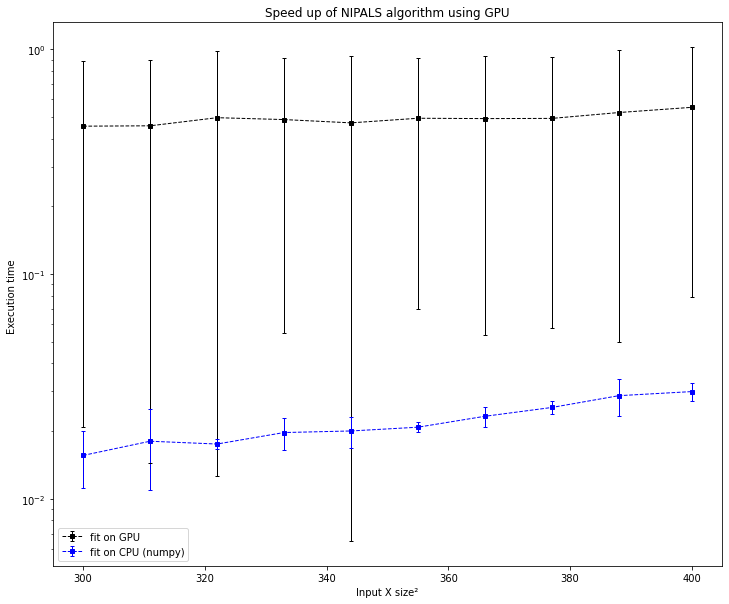

In [ ]:
# NIPALS SPEED-UP

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda import cumath
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

from nipals.NIPALS import Nipals_GPU ,Nipals_CPU

N_ITER = 10
MIN_SIZE = 300
MAX_SIZE = 400
n_components = 2

speed ={} 

nips_gpu = Nipals_GPU(tol=0.001, maxiter=100,ncomp=n_components)
nips_cpu = Nipals_CPU(tol=0.001, maxiter=100,ncomp=n_components)

for size in tqdm(np.linspace(MIN_SIZE,MAX_SIZE,num=10, dtype=int)):
    time_cpu = np.empty(N_ITER)
    time_gpu = np.empty(N_ITER)
    for it in range(N_ITER):
        X = np.random.randn(size, size)
        ## Fit on GPU :
        t1 = time()
        nips_gpu.fit_on_GPU(X)
        t2 = time()
        time_gpu[it] = t2-t1
        ## Fit on CPU :
        t1 = time()
        nips_cpu.fit(X)
        t2 = time()
        time_cpu[it] = t2-t1
    speed[size] = {
        "mean_time_gpu": np.mean(time_gpu),
        "std_time_gpu": np.std(time_gpu),
        "mean_time_cpu": np.mean(time_cpu),
        "std_time_cpu": np.std(time_cpu),
        }

res = pd.DataFrame(speed)
res = res.transpose()
res.to_csv('result2.csv')
plt.figure(figsize=(12,10))
plt.errorbar(x= res.index,y=res.mean_time_gpu, yerr=res.std_time_gpu, 
            marker='s', capsize=2,color='black', markersize=4, linewidth=1, linestyle='--',
            label='fit on GPU')

plt.errorbar(x= res.index,y=res.mean_time_cpu, yerr=res.std_time_cpu, 
            marker='s', capsize=2,color='blue', markersize=4, linewidth=1, linestyle='--',
            label='fit on CPU (numpy)')


plt.ylabel("Execution time ")
plt.xlabel("Input X size²")
plt.yscale('log')
plt.title('Speed up of NIPALS algorithm using GPU')
plt.legend()
plt.savefig('speedup.png')

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
  5%|▌         | 1/20 [00:15<04:45, 15.04s/it]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
 10%|█         | 2/20 [00:32<05:00, 16.67s/it]/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWarning: module in out-of-thread context could not be cleaned up
  frame = None
/usr/local/lib/python3.8/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py:596: UserWa

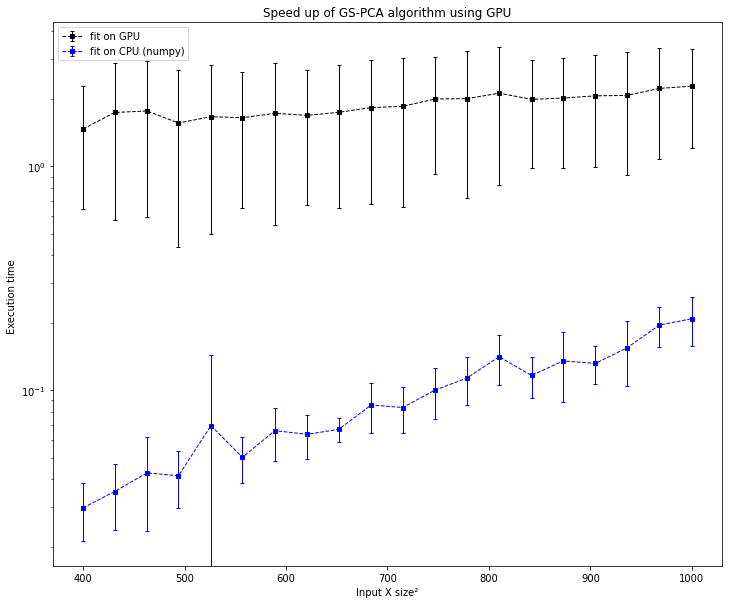

In [ ]:
# GS-PGA SPEEDUP

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda import cumath
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

from GS_PCA.GSPCA import GS_PCA_CPU , GS_PCA_GPU

N_ITER = 10
MIN_SIZE = 400
MAX_SIZE = 1000
n_components = 2

speed ={} 

for size in tqdm(np.linspace(MIN_SIZE,MAX_SIZE,num=20, dtype=int)):
    time_cpu = np.empty(N_ITER)
    time_gpu = np.empty(N_ITER)
    for it in range(N_ITER):
        X = np.random.randn(size, size)
        ## Fit on GPU :
        t1 = time()
        T, P, R, Lambda, vectL = GS_PCA_GPU(X, n=n_components, epsilon=1e-3)
        t2 = time()
        time_gpu[it] = t2-t1
        ## Fit on CPU :
        t1 = time()
        T, P, R, Lambda, vectL = GS_PCA_CPU(X, n=n_components, epsilon=1e-3)
        t2 = time()
        time_cpu[it] = t2-t1
        speed[size] = {
        "mean_time_gpu": np.mean(time_gpu),
        "std_time_gpu": np.std(time_gpu),
        "mean_time_cpu": np.mean(time_cpu),
        "std_time_cpu": np.std(time_cpu),
        }

res = pd.DataFrame(speed)
res = res.transpose()

res.to_csv('result4.csv')
plt.figure(figsize=(12,10))
plt.errorbar(x= res.index,y=res.mean_time_gpu, yerr=res.std_time_gpu, 
            marker='s', capsize=2,color='black', markersize=4, linewidth=1, linestyle='--',
            label='fit on GPU')

plt.errorbar(x= res.index,y=res.mean_time_cpu, yerr=res.std_time_cpu, 
            marker='s', capsize=2,color='blue', markersize=4, linewidth=1, linestyle='--',
            label='fit on CPU (numpy)')


plt.ylabel("Execution time ")
plt.xlabel("Input X size²")
plt.yscale('log')
plt.title('Speed up of GS-PCA algorithm using GPU')
plt.legend()
plt.savefig('speedup_GSPCA_400_1000.png')